# Disentangled Representational Learning of Single Lead Electrocardiogram Signals using  Variational Autoencoder

### Imports

In [837]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import ipywidgets as widgets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.metrics.disentanglement import Disentanglement
from src.utils.helper import Helper
from src.utils.visualizations import Visualizations

### Path Selection

In [838]:
val = widgets.Dropdown(
    options=sorted(glob.glob('../results/*')),
    description='Base path:',
    disabled=False,
)

In [839]:
val

Dropdown(description='Base path:', options=('../results/2024-01-21_19-32-44', '../results/2024-01-21_20-50-38'…

In [840]:
path_base = val.value + '/'
path_embedding = path_base + 'evaluation/embedding/'
path_personalization = path_base + 'evaluation/personalization/'
path_training = path_base + 'training/'

### 0. General

In [841]:
params = Helper.load_yaml_file(path_base + 'params.json')

In [842]:
params['coefficients']

{'alpha': 1.0, 'beta': 3.0, 'gamma': 3.0}

In [843]:
train_progress = pd.read_csv(path_training + 'training_progress.csv')

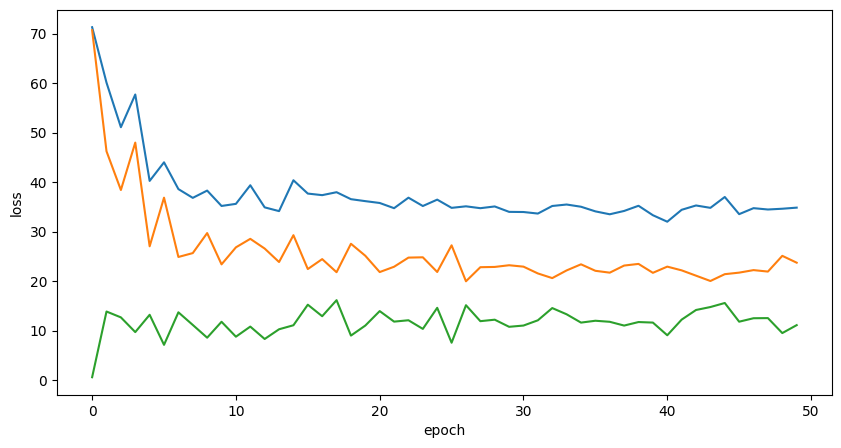

In [844]:
Visualizations.plot_trainings_process(train_progress[0:250], ['loss', 'recon', 'kl_loss'])

### 1. Disentanglement

In [845]:
df, ld = Helper.load_embedding(path_embedding, 'synth', 'train')

In [846]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

In [850]:
n = 4

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


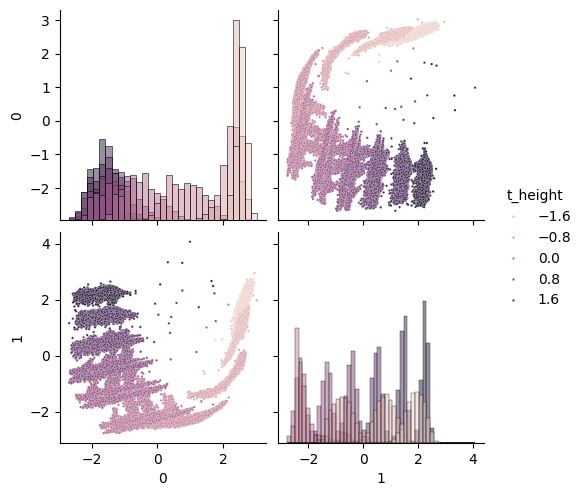

In [851]:
ax = sns.pairplot(pca_data[[0,1,df.columns[n]]], hue=df.columns[n], diag_kind="hist", plot_kws={"s": 3})

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


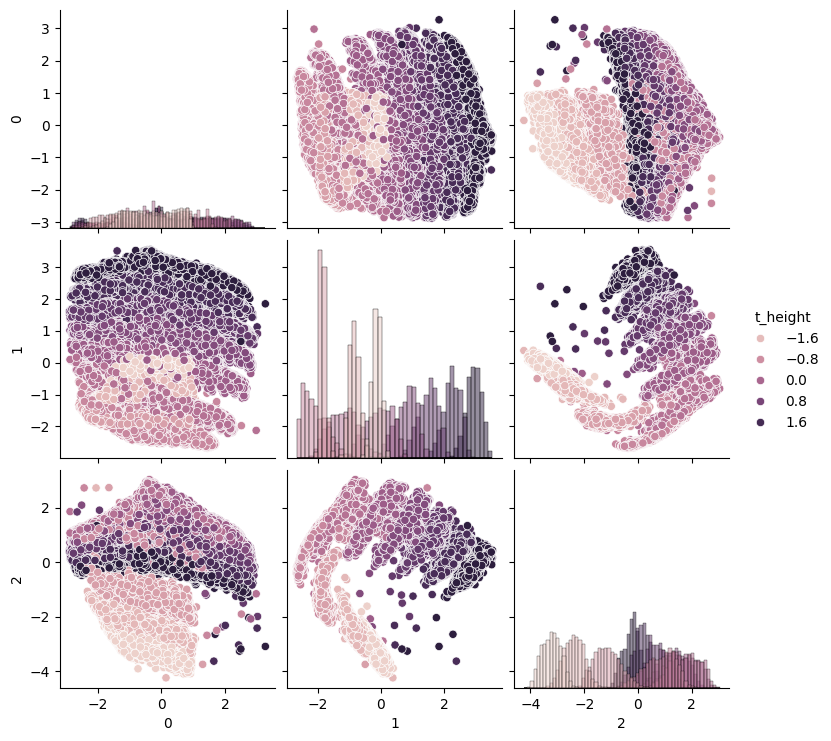

In [852]:
ax = sns.pairplot(df[[0,1,2, 't_height']], hue="t_height", diag_kind="hist")

In [853]:
#ax = sns.pairplot(df[[0,1,2,3,4,5,6,7, 'p_height']], hue="p_height", diag_kind="hist")

In [854]:
#ax = sns.pairplot(df[[0,1,2,3,4,5,6,7, 'q_height']], hue="q_height", diag_kind="hist")

In [855]:
mus_train = np.array(df.iloc[:, :ld])
ys_train = np.array(df.iloc[:, ld:])

In [856]:
Disentanglement.compute_mig(mus_train, ys_train)

{'discrete_mig': 0.18609338739516443}

In [489]:
#model = tf.keras.models.load_model(path_base + 'model/')
#mu = np.mean(df.iloc[:,:ld], axis=0)
#std = np.std(df.iloc[:,:ld], axis=0)
#M = np.zeros(shape=(5000, ld))
#M[:, 0] = np.linspace(mu[0] - 3*std[0], mu[0] + 3*std[0], M.shape[0])
#M[:, 1] = mu[1]
#plt.figure(figsize=(15, 5))
#plt.plot(range(0, len(mean)), mean, 'k-')
#plt.fill_between(range(0, len(mean)), mu - std, mu + std)

### 2. Anomaly Detection

In [740]:
df, ld = Helper.load_embedding(path_embedding, 'zheng', 'train')

In [709]:
a = ['SB', 'SR', 'AFIB', 'ST', 'AF', 'SI', 'SVT', 'AT', 'AVNRT', 'AVRT', 'SAAWR', 'SA']

In [707]:
for k in range(0, len(a)):
    df.rhythm = df.rhythm.replace(float(k), k) #a[k])

In [741]:
q = 0
for k in df.rhythm.unique():
    print(k, q)
    df.rhythm = df.rhythm.replace(k, str(q)) #a[k])
    q = q+1

1.0 0
0.0 1
6.0 2
3.0 3
2.0 4
4.0 5
11.0 6
7.0 7
10.0 8
8.0 9
9.0 10


In [711]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:ld], df['rhythm'], test_size=0.2, random_state=42)

In [742]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

parameters = {
    'colsample_bytree': [0.7],
    'learning_rate': [0.05],
    'max_depth': [4, 5, 6, 7],
    'n_estimators': [180],
}

estimator = XGBClassifier(
    nthread=8,
    max_depth=5,
    seed=42
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    #scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=4
)

estimator.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=8,
              num_parallel_tree=None, ...)

In [743]:
from sklearn.metrics import accuracy_score

In [744]:
predictions

array([1, 1, 0, ..., 4, 4, 1])

In [745]:
np.array(y_test.astype(int)) - predictions

array([ 0,  0,  6, ...,  0, -4,  0])

In [746]:
y_test

10560    1
5636     1
9191     6
2515     4
958      1
        ..
7932     1
1482     1
3544     4
2846     0
2802     1
Name: rhythm, Length: 2119, dtype: object

Accuracy: 67.67%


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (3).

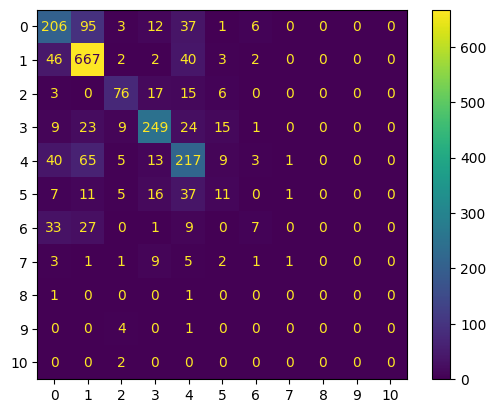

In [748]:
predictions = estimator.predict(X_test)
accuracy = accuracy_score(y_test.astype(int), predictions)
print("Accuracy: %.2f%%" % (accuracy*100.0))

cm = confusion_matrix(y_test.astype(int), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'PAC', 'PVC'])
disp.plot()
plt.show()

In [556]:
#tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:], TSNE(n_components=2))

In [557]:
pca_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


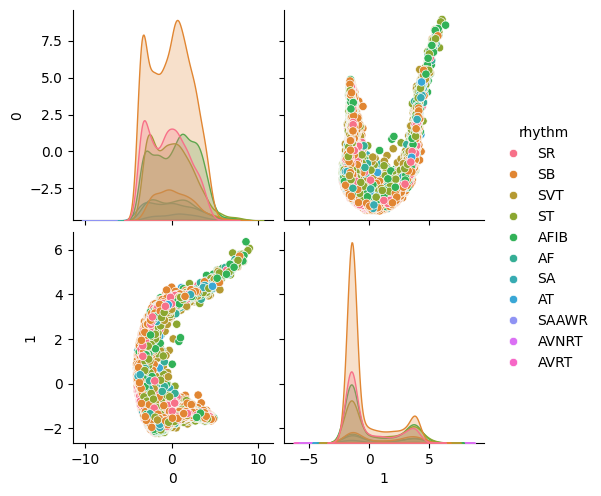

In [558]:
sns.pairplot(pca_data[[0, 1, 'rhythm']], hue="rhythm")

In [559]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [560]:
predictions = neigh.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

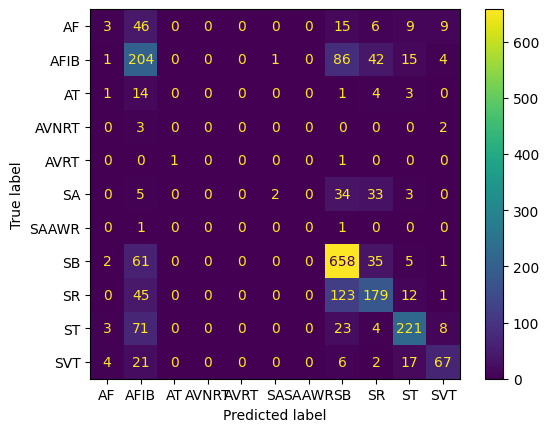

In [561]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [562]:
np.trace(cm) / np.sum(cm)

0.6295422369042001

In [566]:
mus_train = np.array(df.iloc[:, :ld])
ys_train = np.array(df.iloc[:, ld:])
Disentanglement.compute_mig(mus_train, ys_train)

/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  warnings.warn(
/mnt/sdb/home/ml/Desktop/VECG/venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  wa

{'discrete_mig': nan}

### 3. Personalization

In [761]:
df, ld = Helper.load_embedding(path_personalization, 'icentia11k', '5484')

In [762]:
df.beat = df.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')

In [763]:
#df.beat = df.beat.replace(0.0, 0).replace(1.0, 4).replace(2.0, 1).replace(3.0, 2)

In [764]:
tsne_data = Helper.embedding(df.iloc[:, 0:ld], df.iloc[:, ld:])

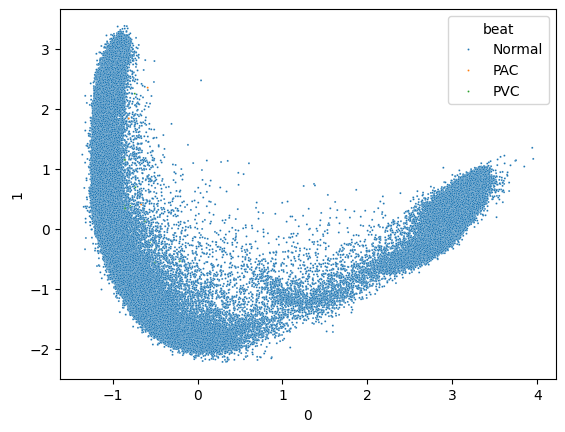

In [765]:
ax = sns.scatterplot(data=tsne_data[df.beat != 'Unclassified'], x=0, y=1, hue="beat", s=2)

In [766]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df.beat != 'Unclassified'].iloc[:, 0:ld],
    df[df.beat != 'Unclassified']['beat'],
    test_size=0.2,
    random_state=42,
)

In [771]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(np.array(X_train), y_train)
predictions = neigh.predict(X_test)

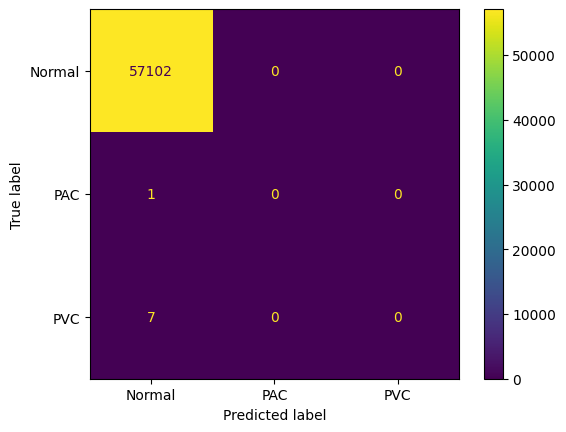

In [772]:
cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot()
plt.show()

In [773]:
np.trace(cm) / np.sum(cm)

0.9998599194536859

In [774]:
cm

array([[57102,     0,     0],
       [    1,     0,     0],
       [    7,     0,     0]])